In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import numpy as np
import trees
from trees.ddt import DirichletDiffusionTree, Inverse, GaussianLikelihoodModel
from trees.mcmc import MetropolisHastingsSampler
from trees.util import plot_tree, plot_tree_2d
import mpld3
import seaborn as sns
sns.set_style('white')
from tqdm import tqdm
from sklearn.decomposition import PCA
import cPickle as pickle

INFO:root:Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


[[ 4.71223324 -0.68507286]
 [-0.68507286  1.0151647 ]]


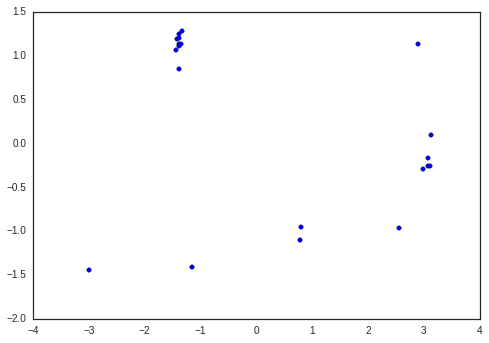

In [5]:
X, y = trees.data.load('zoo')
pca = PCA(n_components=2)
X = pca.fit_transform(X)
X += np.random.normal(scale=0.05, size=X.shape)
idx = xrange(20)
X = X[idx]
print np.cov(X.T)
N, D = X.shape
scatter(*X.T);
with open('../scripts/zoo.tree', 'rb') as fp:
    master_tree = pickle.load(fp).induced_subtree(idx)
master_constraints = list(master_tree.generate_constraints())
train_constraints, test_constraints = master_constraints[:200], master_constraints[200:]

INFO:root:Compiling <Inverse> object...
INFO:root:Done compiling <Inverse> object.
INFO:root:Compiling <GaussianLikelihoodModel> object...
INFO:root:Done compiling <GaussianLikelihoodModel> object.
INFO:root:Compiling <GaussianLikelihoodModel> object...
INFO:root:Done compiling <GaussianLikelihoodModel> object.


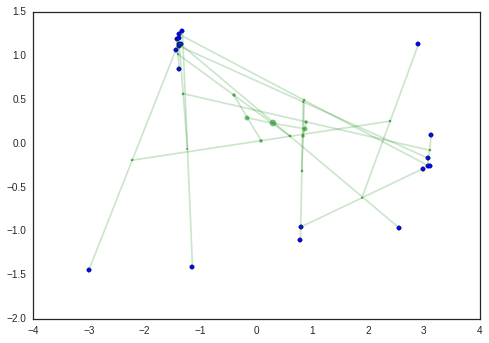

In [11]:
df = Inverse(c=1)

lm = GaussianLikelihoodModel(sigma=np.cov(X.T) / 4.0, sigma0=np.eye(D) / 2.0, mu0=X.mean(axis=0)).compile()
sampler = MetropolisHastingsSampler(DirichletDiffusionTree(df=df, likelihood_model=lm, constraints=[]), X)
sampler.initialize_assignments()

def iterate(n_iters):
    lls, score = [], []
    for i in tqdm(xrange(n_iters)):
        old_tree = sampler.tree
        sampler.sample()
        lls.append(sampler.tree.marg_log_likelihood())
        score.append(sampler.tree.score_constraints(test_constraints))
    return lls, score

plot_tree_2d(sampler.tree, X)

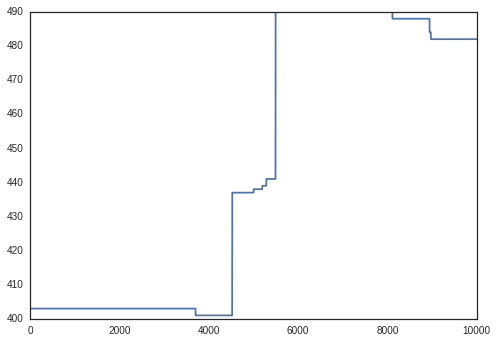

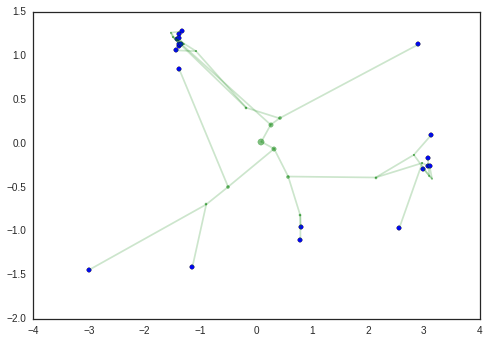

In [13]:
lls, score = iterate(10000)
plot(score)
figure()
plot_tree_2d(sampler.tree, X)

In [ ]:
fig = plot_tree(master_tree, mpld3=True, y=y)
mpld3.display()

In [9]:
float(sampler.tree.score_constraints(test_constraints)) / len(test_constraints)

0.9617021276595744

In [ ]:
sampler.sample()
print float(sampler.tree.score_constraints(master_constraints)) / len(master_constraints)

In [ ]:
X[y.index('aardvark')]

In [ ]:
sampler.X